In [32]:
import os
import gymnasium as gym
import flappy_bird_gymnasium as flappy_bird
import torch
import numpy as np
import matplotlib.pyplot as plt

from collections import deque, defaultdict
from gymnasium.wrappers import RecordVideo

import sys
sys.path.append(os.path.abspath("../"))

from model import DQN_CNN
from save_model.utils import transition
import tqdm


plt.rcParams["figure.figsize"] = (10, 5)


In [33]:
MODEL_PATH = "../best_dqn.pt"
ENV_NAME = "FlappyBird-v0"
DEVICE = "cpu"

NUM_EPISODES = 300
FRAME_SKIP = 4
MAX_STEPS = 10_000  # safety cap


In [34]:
state_dict = torch.load("../best_dqn.pt", map_location=DEVICE)
for k, v in state_dict.items():
    print(k, v.shape)


conv1.weight torch.Size([32, 4, 8, 8])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 4, 4])
conv2.bias torch.Size([64])
conv3.weight torch.Size([64, 64, 3, 3])
conv3.bias torch.Size([64])
fc1.weight torch.Size([512, 3136])
fc1.bias torch.Size([512])
fc2.weight torch.Size([2, 512])
fc2.bias torch.Size([2])
net.0.weight torch.Size([32, 4, 8, 8])
net.0.bias torch.Size([32])
net.2.weight torch.Size([64, 32, 4, 4])
net.2.bias torch.Size([64])
net.4.weight torch.Size([64, 64, 3, 3])
net.4.bias torch.Size([64])
net.7.weight torch.Size([512, 3136])
net.7.bias torch.Size([512])
net.8.weight torch.Size([512])
net.8.bias torch.Size([512])
net.10.weight torch.Size([2, 512])
net.10.bias torch.Size([2])


In [35]:
policy_net = DQN_CNN(FRAME_SKIP).to(DEVICE)
for k, v in policy_net.state_dict().items():
    print(k, v.shape)


state_dict = torch.load("../best_dqn.pt", map_location=DEVICE)
policy_net.load_state_dict(state_dict)

policy_net.eval()
print("✅ Model loaded")



conv1.weight torch.Size([32, 4, 8, 8])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 4, 4])
conv2.bias torch.Size([64])
conv3.weight torch.Size([64, 64, 3, 3])
conv3.bias torch.Size([64])
fc1.weight torch.Size([512, 3136])
fc1.bias torch.Size([512])
fc2.weight torch.Size([2, 512])
fc2.bias torch.Size([2])
net.0.weight torch.Size([32, 4, 8, 8])
net.0.bias torch.Size([32])
net.2.weight torch.Size([64, 32, 4, 4])
net.2.bias torch.Size([64])
net.4.weight torch.Size([64, 64, 3, 3])
net.4.bias torch.Size([64])
net.7.weight torch.Size([512, 3136])
net.7.bias torch.Size([512])
net.8.weight torch.Size([512])
net.8.bias torch.Size([512])
net.10.weight torch.Size([2, 512])
net.10.bias torch.Size([2])
✅ Model loaded


In [36]:
def run_single_episode(env, model, frame_skip, device):
    frame_stack = deque(maxlen=frame_skip)

    state, _ = env.reset()
    done = False
    steps = 0

    total_reward = 0.0
    alive_frames = 0
    pipes_passed = 0
    deaths = 0
    top_hits = 0

    current_state, _, _ = transition(0, env, frame_skip)

    while not done and steps < MAX_STEPS:
        with torch.no_grad():
            state_t = torch.tensor(
                current_state, dtype=torch.float32
            ).unsqueeze(0).to(device)
            action = model(state_t).argmax(dim=1).item()

        next_state, reward_sum, done = transition(action, env, frame_skip)
        current_state = next_state

        total_reward += reward_sum
        steps += 1

        # ---------- reward decomposition ----------
        if reward_sum > 0:
            alive_frames += reward_sum / 0.1
            if reward_sum >= 1.0:
                pipes_passed += int(reward_sum // 1.0)

        if reward_sum <= -1.0:
            deaths += 1
        if reward_sum <= -0.5:
            top_hits += 1

    return {
        "total_reward": total_reward,
        "steps": steps,
        "alive_frames": alive_frames,
        "pipes_passed": pipes_passed,
        "deaths": deaths,
        "top_hits": top_hits,
    }


In [37]:
env = gym.make(ENV_NAME, render_mode="rgb_array")


metrics = defaultdict(list)

for episode in tqdm.tqdm(range(NUM_EPISODES)):
    episode_metrics = run_single_episode(
        env, policy_net, FRAME_SKIP, DEVICE
    )

    for k, v in episode_metrics.items():
        metrics[k].append(v)

    print(
        f"Episode {episode+1:03d} | "
        f"Reward: {episode_metrics['total_reward']:.2f} | "
        f"Pipes: {episode_metrics['pipes_passed']}"
    )

env.close()


  0%|          | 1/300 [00:44<3:42:27, 44.64s/it]

Episode 001 | Reward: 301.00 | Pipes: 91


  1%|          | 2/300 [00:46<1:35:33, 19.24s/it]

Episode 002 | Reward: 13.90 | Pipes: 2


  1%|          | 3/300 [01:21<2:10:52, 26.44s/it]

Episode 003 | Reward: 259.20 | Pipes: 79


  1%|▏         | 4/300 [01:23<1:23:16, 16.88s/it]

Episode 004 | Reward: 18.00 | Pipes: 5


  2%|▏         | 5/300 [01:26<58:58, 12.00s/it]  

Episode 005 | Reward: 17.80 | Pipes: 8


  2%|▏         | 6/300 [01:28<41:46,  8.53s/it]

Episode 006 | Reward: 22.20 | Pipes: 5


  2%|▏         | 7/300 [01:34<36:53,  7.55s/it]

Episode 007 | Reward: 37.10 | Pipes: 11


  3%|▎         | 8/300 [01:56<1:00:18, 12.39s/it]

Episode 008 | Reward: 152.80 | Pipes: 49


  3%|▎         | 9/300 [01:58<44:42,  9.22s/it]  

Episode 009 | Reward: 18.80 | Pipes: 6


  3%|▎         | 10/300 [02:12<51:19, 10.62s/it]

Episode 010 | Reward: 104.40 | Pipes: 32


  4%|▎         | 11/300 [02:16<41:40,  8.65s/it]

Episode 011 | Reward: 33.30 | Pipes: 8


  4%|▍         | 12/300 [02:25<41:55,  8.73s/it]

Episode 012 | Reward: 79.90 | Pipes: 17


  4%|▍         | 13/300 [02:34<41:14,  8.62s/it]

Episode 013 | Reward: 62.20 | Pipes: 19


  5%|▍         | 14/300 [02:40<38:21,  8.05s/it]

Episode 014 | Reward: 51.30 | Pipes: 23


  5%|▌         | 15/300 [03:00<55:07, 11.61s/it]

Episode 015 | Reward: 131.50 | Pipes: 48


  5%|▌         | 16/300 [03:17<1:01:33, 13.01s/it]

Episode 016 | Reward: 128.70 | Pipes: 32


  6%|▌         | 17/300 [03:29<1:00:30, 12.83s/it]

Episode 017 | Reward: 86.20 | Pipes: 26


  6%|▌         | 18/300 [04:14<1:46:07, 22.58s/it]

Episode 018 | Reward: 339.00 | Pipes: 96


  6%|▋         | 19/300 [04:23<1:26:27, 18.46s/it]

Episode 019 | Reward: 69.10 | Pipes: 22


  7%|▋         | 20/300 [04:25<1:03:10, 13.54s/it]

Episode 020 | Reward: 14.40 | Pipes: 3


  7%|▋         | 21/300 [05:20<2:01:04, 26.04s/it]

Episode 021 | Reward: 377.40 | Pipes: 115


  7%|▋         | 22/300 [05:41<1:53:36, 24.52s/it]

Episode 022 | Reward: 133.50 | Pipes: 45


  8%|▊         | 23/300 [06:25<2:19:43, 30.27s/it]

Episode 023 | Reward: 296.80 | Pipes: 86


  8%|▊         | 24/300 [06:35<1:50:33, 24.04s/it]

Episode 024 | Reward: 49.50 | Pipes: 19


  8%|▊         | 25/300 [07:01<1:52:52, 24.63s/it]

Episode 025 | Reward: 192.10 | Pipes: 61


  9%|▊         | 26/300 [07:20<1:46:03, 23.22s/it]

Episode 026 | Reward: 148.90 | Pipes: 32


  9%|▉         | 27/300 [07:41<1:42:33, 22.54s/it]

Episode 027 | Reward: 146.70 | Pipes: 48


  9%|▉         | 28/300 [07:47<1:19:37, 17.56s/it]

Episode 028 | Reward: 43.80 | Pipes: 14


 10%|▉         | 29/300 [08:37<2:02:14, 27.07s/it]

Episode 029 | Reward: 343.90 | Pipes: 92


 10%|█         | 30/300 [08:48<1:41:04, 22.46s/it]

Episode 030 | Reward: 102.00 | Pipes: 24


 10%|█         | 31/300 [09:02<1:28:26, 19.73s/it]

Episode 031 | Reward: 82.50 | Pipes: 28


 11%|█         | 32/300 [09:08<1:10:34, 15.80s/it]

Episode 032 | Reward: 53.00 | Pipes: 14


 11%|█         | 33/300 [09:42<1:33:38, 21.04s/it]

Episode 033 | Reward: 242.80 | Pipes: 76


 11%|█▏        | 34/300 [09:53<1:21:08, 18.30s/it]

Episode 034 | Reward: 95.70 | Pipes: 31


 12%|█▏        | 35/300 [09:58<1:02:56, 14.25s/it]

Episode 035 | Reward: 27.90 | Pipes: 11


 12%|█▏        | 36/300 [10:30<1:25:55, 19.53s/it]

Episode 036 | Reward: 257.10 | Pipes: 73


 12%|█▏        | 37/300 [10:41<1:14:02, 16.89s/it]

Episode 037 | Reward: 65.90 | Pipes: 22


 13%|█▎        | 38/300 [11:21<1:44:24, 23.91s/it]

Episode 038 | Reward: 295.70 | Pipes: 87


 13%|█▎        | 39/300 [12:24<2:35:00, 35.63s/it]

Episode 039 | Reward: 465.80 | Pipes: 151


 13%|█▎        | 40/300 [13:07<2:43:26, 37.72s/it]

Episode 040 | Reward: 297.40 | Pipes: 87


 14%|█▎        | 41/300 [13:12<2:01:14, 28.09s/it]

Episode 041 | Reward: 36.70 | Pipes: 8


 14%|█▍        | 42/300 [13:27<1:43:21, 24.04s/it]

Episode 042 | Reward: 124.20 | Pipes: 34


 14%|█▍        | 43/300 [13:56<1:49:21, 25.53s/it]

Episode 043 | Reward: 216.60 | Pipes: 63


 15%|█▍        | 44/300 [13:59<1:20:10, 18.79s/it]

Episode 044 | Reward: 21.70 | Pipes: 7


 15%|█▌        | 45/300 [14:36<1:42:58, 24.23s/it]

Episode 045 | Reward: 272.80 | Pipes: 86


 15%|█▌        | 46/300 [14:44<1:22:18, 19.44s/it]

Episode 046 | Reward: 67.60 | Pipes: 17


 16%|█▌        | 47/300 [14:58<1:15:28, 17.90s/it]

Episode 047 | Reward: 129.10 | Pipes: 32


 16%|█▌        | 48/300 [15:57<2:06:49, 30.20s/it]

Episode 048 | Reward: 441.40 | Pipes: 136


 16%|█▋        | 49/300 [16:45<2:28:41, 35.54s/it]

Episode 049 | Reward: 337.10 | Pipes: 107


 17%|█▋        | 50/300 [16:53<1:52:36, 27.03s/it]

Episode 050 | Reward: 48.30 | Pipes: 15


 17%|█▋        | 51/300 [17:07<1:36:02, 23.14s/it]

Episode 051 | Reward: 107.20 | Pipes: 33


 17%|█▋        | 52/300 [18:45<3:09:04, 45.74s/it]

Episode 052 | Reward: 744.00 | Pipes: 228


 18%|█▊        | 53/300 [18:51<2:18:40, 33.69s/it]

Episode 053 | Reward: 53.90 | Pipes: 14


 18%|█▊        | 54/300 [19:52<2:52:15, 42.02s/it]

Episode 054 | Reward: 464.40 | Pipes: 150


 18%|█▊        | 55/300 [20:21<2:35:00, 37.96s/it]

Episode 055 | Reward: 177.10 | Pipes: 49


 19%|█▊        | 56/300 [20:29<1:57:41, 28.94s/it]

Episode 056 | Reward: 60.70 | Pipes: 22


 19%|█▉        | 57/300 [21:03<2:04:01, 30.62s/it]

Episode 057 | Reward: 266.80 | Pipes: 79


 19%|█▉        | 58/300 [21:21<1:47:49, 26.73s/it]

Episode 058 | Reward: 131.30 | Pipes: 36


 20%|█▉        | 59/300 [21:45<1:44:29, 26.02s/it]

Episode 059 | Reward: 174.80 | Pipes: 46


 20%|██        | 60/300 [21:53<1:22:19, 20.58s/it]

Episode 060 | Reward: 60.70 | Pipes: 16


 20%|██        | 61/300 [22:00<1:06:01, 16.58s/it]

Episode 061 | Reward: 62.60 | Pipes: 15


 21%|██        | 62/300 [22:25<1:15:17, 18.98s/it]

Episode 062 | Reward: 175.40 | Pipes: 54


 21%|██        | 63/300 [23:35<2:15:22, 34.27s/it]

Episode 063 | Reward: 525.70 | Pipes: 159


 21%|██▏       | 64/300 [24:11<2:16:50, 34.79s/it]

Episode 064 | Reward: 246.50 | Pipes: 85


 22%|██▏       | 65/300 [24:20<1:46:49, 27.28s/it]

Episode 065 | Reward: 74.70 | Pipes: 24


 22%|██▏       | 66/300 [24:42<1:39:46, 25.58s/it]

Episode 066 | Reward: 173.70 | Pipes: 57


 22%|██▏       | 67/300 [24:50<1:18:30, 20.22s/it]

Episode 067 | Reward: 41.00 | Pipes: 19


 23%|██▎       | 68/300 [25:24<1:34:52, 24.54s/it]

Episode 068 | Reward: 247.40 | Pipes: 80


 23%|██▎       | 69/300 [25:59<1:46:25, 27.64s/it]

Episode 069 | Reward: 257.00 | Pipes: 82


 23%|██▎       | 70/300 [26:20<1:37:58, 25.56s/it]

Episode 070 | Reward: 166.50 | Pipes: 51


 24%|██▎       | 71/300 [26:42<1:33:16, 24.44s/it]

Episode 071 | Reward: 164.30 | Pipes: 43


 24%|██▍       | 72/300 [27:22<1:51:15, 29.28s/it]

Episode 072 | Reward: 305.60 | Pipes: 93


 24%|██▍       | 73/300 [27:25<1:20:10, 21.19s/it]

Episode 073 | Reward: 21.00 | Pipes: 6


 25%|██▍       | 74/300 [27:40<1:13:37, 19.55s/it]

Episode 074 | Reward: 129.10 | Pipes: 40


 25%|██▌       | 75/300 [27:44<55:13, 14.73s/it]  

Episode 075 | Reward: 31.70 | Pipes: 7


 25%|██▌       | 76/300 [28:06<1:03:04, 16.89s/it]

Episode 076 | Reward: 174.80 | Pipes: 52


 26%|██▌       | 77/300 [28:21<1:01:11, 16.46s/it]

Episode 077 | Reward: 121.90 | Pipes: 43


 26%|██▌       | 78/300 [28:30<52:10, 14.10s/it]  

Episode 078 | Reward: 61.60 | Pipes: 19


 26%|██▋       | 79/300 [28:58<1:06:51, 18.15s/it]

Episode 079 | Reward: 196.70 | Pipes: 52


 27%|██▋       | 80/300 [29:14<1:04:34, 17.61s/it]

Episode 080 | Reward: 99.80 | Pipes: 38


 27%|██▋       | 81/300 [29:26<58:07, 15.93s/it]  

Episode 081 | Reward: 99.50 | Pipes: 29


 27%|██▋       | 82/300 [30:44<2:05:11, 34.46s/it]

Episode 082 | Reward: 548.70 | Pipes: 162


 28%|██▊       | 83/300 [31:30<2:17:24, 37.99s/it]

Episode 083 | Reward: 347.10 | Pipes: 101


 28%|██▊       | 84/300 [32:12<2:20:56, 39.15s/it]

Episode 084 | Reward: 312.90 | Pipes: 94


 28%|██▊       | 85/300 [32:52<2:21:37, 39.52s/it]

Episode 085 | Reward: 314.70 | Pipes: 85


 29%|██▊       | 86/300 [33:53<2:44:08, 46.02s/it]

Episode 086 | Reward: 463.40 | Pipes: 125


 29%|██▉       | 87/300 [33:56<1:57:20, 33.05s/it]

Episode 087 | Reward: 22.70 | Pipes: 6


 29%|██▉       | 88/300 [34:05<1:31:16, 25.83s/it]

Episode 088 | Reward: 64.60 | Pipes: 17


 30%|██▉       | 89/300 [34:27<1:26:34, 24.62s/it]

Episode 089 | Reward: 138.90 | Pipes: 39


 30%|███       | 90/300 [34:57<1:31:44, 26.21s/it]

Episode 090 | Reward: 230.40 | Pipes: 72


 30%|███       | 91/300 [35:28<1:36:28, 27.70s/it]

Episode 091 | Reward: 264.40 | Pipes: 67


 31%|███       | 92/300 [35:33<1:12:07, 20.81s/it]

Episode 092 | Reward: 32.70 | Pipes: 10


 31%|███       | 93/300 [35:35<52:38, 15.26s/it]  

Episode 093 | Reward: 20.90 | Pipes: 4


 31%|███▏      | 94/300 [36:07<1:09:59, 20.38s/it]

Episode 094 | Reward: 224.30 | Pipes: 70


 32%|███▏      | 95/300 [36:17<59:03, 17.29s/it]  

Episode 095 | Reward: 84.30 | Pipes: 23


 32%|███▏      | 96/300 [36:31<55:26, 16.30s/it]

Episode 096 | Reward: 92.90 | Pipes: 32


 32%|███▏      | 97/300 [36:34<41:03, 12.14s/it]

Episode 097 | Reward: 12.30 | Pipes: 5


 33%|███▎      | 98/300 [36:53<48:13, 14.33s/it]

Episode 098 | Reward: 139.90 | Pipes: 46


 33%|███▎      | 99/300 [37:05<45:15, 13.51s/it]

Episode 099 | Reward: 88.80 | Pipes: 29


 33%|███▎      | 100/300 [37:42<1:08:55, 20.68s/it]

Episode 100 | Reward: 296.00 | Pipes: 86


 34%|███▎      | 101/300 [38:11<1:16:12, 22.98s/it]

Episode 101 | Reward: 216.70 | Pipes: 59


 34%|███▍      | 102/300 [38:36<1:18:28, 23.78s/it]

Episode 102 | Reward: 189.20 | Pipes: 53


 34%|███▍      | 103/300 [40:20<2:36:43, 47.74s/it]

Episode 103 | Reward: 812.40 | Pipes: 234


 35%|███▍      | 104/300 [40:25<1:54:29, 35.05s/it]

Episode 104 | Reward: 27.80 | Pipes: 10


 35%|███▌      | 105/300 [40:39<1:32:57, 28.60s/it]

Episode 105 | Reward: 105.00 | Pipes: 26


 35%|███▌      | 106/300 [40:44<1:10:02, 21.66s/it]

Episode 106 | Reward: 31.30 | Pipes: 13


 36%|███▌      | 107/300 [41:15<1:18:05, 24.27s/it]

Episode 107 | Reward: 221.10 | Pipes: 64


 36%|███▌      | 108/300 [41:37<1:15:56, 23.73s/it]

Episode 108 | Reward: 161.40 | Pipes: 56


 36%|███▋      | 109/300 [41:42<57:11, 17.97s/it]  

Episode 109 | Reward: 23.40 | Pipes: 6


 37%|███▋      | 110/300 [41:47<45:12, 14.28s/it]

Episode 110 | Reward: 46.60 | Pipes: 14


 37%|███▋      | 111/300 [41:59<42:40, 13.55s/it]

Episode 111 | Reward: 104.70 | Pipes: 32


 37%|███▋      | 112/300 [42:09<38:31, 12.30s/it]

Episode 112 | Reward: 61.10 | Pipes: 23


 38%|███▊      | 113/300 [42:13<30:45,  9.87s/it]

Episode 113 | Reward: 36.30 | Pipes: 12


 38%|███▊      | 114/300 [42:47<53:10, 17.15s/it]

Episode 114 | Reward: 268.00 | Pipes: 80


 38%|███▊      | 115/300 [44:21<2:04:05, 40.25s/it]

Episode 115 | Reward: 665.10 | Pipes: 215


 39%|███▊      | 116/300 [45:03<2:05:19, 40.87s/it]

Episode 116 | Reward: 317.90 | Pipes: 82


 39%|███▉      | 117/300 [45:16<1:38:33, 32.32s/it]

Episode 117 | Reward: 86.00 | Pipes: 28


 39%|███▉      | 118/300 [45:52<1:41:46, 33.55s/it]

Episode 118 | Reward: 270.10 | Pipes: 87


 40%|███▉      | 119/300 [45:58<1:15:48, 25.13s/it]

Episode 119 | Reward: 47.90 | Pipes: 13


 40%|████      | 120/300 [46:12<1:05:57, 21.99s/it]

Episode 120 | Reward: 102.20 | Pipes: 33


 40%|████      | 121/300 [46:40<1:11:01, 23.80s/it]

Episode 121 | Reward: 178.80 | Pipes: 56


 41%|████      | 122/300 [46:49<57:05, 19.24s/it]  

Episode 122 | Reward: 69.40 | Pipes: 16


 41%|████      | 123/300 [47:31<1:17:01, 26.11s/it]

Episode 123 | Reward: 332.10 | Pipes: 88


 41%|████▏     | 124/300 [47:44<1:05:05, 22.19s/it]

Episode 124 | Reward: 91.00 | Pipes: 32


 42%|████▏     | 125/300 [47:49<49:23, 16.94s/it]  

Episode 125 | Reward: 27.90 | Pipes: 11


 42%|████▏     | 126/300 [47:53<38:23, 13.24s/it]

Episode 126 | Reward: 44.90 | Pipes: 10


 42%|████▏     | 127/300 [47:57<29:32, 10.25s/it]

Episode 127 | Reward: 23.30 | Pipes: 8


 43%|████▎     | 128/300 [48:11<32:51, 11.46s/it]

Episode 128 | Reward: 115.20 | Pipes: 25


 43%|████▎     | 129/300 [48:35<43:32, 15.28s/it]

Episode 129 | Reward: 176.00 | Pipes: 57


 43%|████▎     | 130/300 [48:37<32:15, 11.39s/it]

Episode 130 | Reward: 13.10 | Pipes: 6


 44%|████▎     | 131/300 [48:39<23:41,  8.41s/it]

Episode 131 | Reward: 9.90 | Pipes: 4


 44%|████▍     | 132/300 [48:53<28:17, 10.10s/it]

Episode 132 | Reward: 109.60 | Pipes: 34


 44%|████▍     | 133/300 [48:55<21:40,  7.79s/it]

Episode 133 | Reward: 14.10 | Pipes: 5


 45%|████▍     | 134/300 [49:28<42:28, 15.35s/it]

Episode 134 | Reward: 252.90 | Pipes: 75


 45%|████▌     | 135/300 [49:31<31:35, 11.49s/it]

Episode 135 | Reward: 23.70 | Pipes: 6


 45%|████▌     | 136/300 [49:37<26:43,  9.78s/it]

Episode 136 | Reward: 34.90 | Pipes: 11


 46%|████▌     | 137/300 [49:43<23:36,  8.69s/it]

Episode 137 | Reward: 56.80 | Pipes: 10


 46%|████▌     | 138/300 [49:49<21:44,  8.05s/it]

Episode 138 | Reward: 61.20 | Pipes: 17


 46%|████▋     | 139/300 [49:58<22:25,  8.36s/it]

Episode 139 | Reward: 59.10 | Pipes: 23


 47%|████▋     | 140/300 [50:11<25:31,  9.57s/it]

Episode 140 | Reward: 93.20 | Pipes: 26


 47%|████▋     | 141/300 [50:14<20:17,  7.66s/it]

Episode 141 | Reward: 20.30 | Pipes: 5


 47%|████▋     | 142/300 [50:18<17:23,  6.61s/it]

Episode 142 | Reward: 24.30 | Pipes: 10


 48%|████▊     | 143/300 [50:39<28:40, 10.96s/it]

Episode 143 | Reward: 159.50 | Pipes: 39


 48%|████▊     | 144/300 [50:48<26:51, 10.33s/it]

Episode 144 | Reward: 82.40 | Pipes: 24


 48%|████▊     | 145/300 [51:01<28:32, 11.05s/it]

Episode 145 | Reward: 92.80 | Pipes: 21


 49%|████▊     | 146/300 [51:10<26:35, 10.36s/it]

Episode 146 | Reward: 63.90 | Pipes: 21


 49%|████▉     | 147/300 [51:18<25:05,  9.84s/it]

Episode 147 | Reward: 73.80 | Pipes: 15


 49%|████▉     | 148/300 [51:33<28:52, 11.40s/it]

Episode 148 | Reward: 123.90 | Pipes: 35


 50%|████▉     | 149/300 [51:37<22:47,  9.06s/it]

Episode 149 | Reward: 33.00 | Pipes: 6


 50%|█████     | 150/300 [51:43<20:43,  8.29s/it]

Episode 150 | Reward: 51.10 | Pipes: 16


 50%|█████     | 151/300 [51:51<19:47,  7.97s/it]

Episode 151 | Reward: 49.50 | Pipes: 17


 51%|█████     | 152/300 [52:27<41:01, 16.63s/it]

Episode 152 | Reward: 259.00 | Pipes: 76


 51%|█████     | 153/300 [52:31<31:10, 12.72s/it]

Episode 153 | Reward: 19.80 | Pipes: 8


 51%|█████▏    | 154/300 [52:43<30:18, 12.46s/it]

Episode 154 | Reward: 83.10 | Pipes: 23


 52%|█████▏    | 155/300 [53:27<52:54, 21.90s/it]

Episode 155 | Reward: 311.50 | Pipes: 90


 52%|█████▏    | 156/300 [53:31<39:29, 16.46s/it]

Episode 156 | Reward: 17.80 | Pipes: 8


 52%|█████▏    | 157/300 [54:59<1:30:51, 38.12s/it]

Episode 157 | Reward: 650.40 | Pipes: 201


 53%|█████▎    | 158/300 [55:24<1:20:24, 33.97s/it]

Episode 158 | Reward: 200.30 | Pipes: 55


 53%|█████▎    | 159/300 [55:29<59:32, 25.34s/it]  

Episode 159 | Reward: 45.40 | Pipes: 13


 53%|█████▎    | 160/300 [56:39<1:30:19, 38.71s/it]

Episode 160 | Reward: 531.40 | Pipes: 150


 54%|█████▎    | 161/300 [56:47<1:08:16, 29.47s/it]

Episode 161 | Reward: 57.60 | Pipes: 17


 54%|█████▍    | 162/300 [57:14<1:06:14, 28.80s/it]

Episode 162 | Reward: 213.30 | Pipes: 58


 54%|█████▍    | 163/300 [58:09<1:24:06, 36.83s/it]

Episode 163 | Reward: 386.40 | Pipes: 128


 55%|█████▍    | 164/300 [58:34<1:15:12, 33.18s/it]

Episode 164 | Reward: 196.60 | Pipes: 55


 55%|█████▌    | 165/300 [58:58<1:08:24, 30.41s/it]

Episode 165 | Reward: 175.40 | Pipes: 52


 55%|█████▌    | 166/300 [59:13<57:25, 25.71s/it]  

Episode 166 | Reward: 112.50 | Pipes: 35


 56%|█████▌    | 167/300 [59:19<44:08, 19.91s/it]

Episode 167 | Reward: 40.30 | Pipes: 12


 56%|█████▌    | 168/300 [59:40<44:29, 20.23s/it]

Episode 168 | Reward: 159.90 | Pipes: 49


 56%|█████▋    | 169/300 [1:00:07<48:40, 22.30s/it]

Episode 169 | Reward: 191.70 | Pipes: 67


 57%|█████▋    | 170/300 [1:01:02<1:09:33, 32.10s/it]

Episode 170 | Reward: 438.90 | Pipes: 128


 57%|█████▋    | 171/300 [1:01:20<59:59, 27.90s/it]  

Episode 171 | Reward: 142.20 | Pipes: 39


 57%|█████▋    | 172/300 [1:01:26<45:35, 21.37s/it]

Episode 172 | Reward: 50.20 | Pipes: 11


 58%|█████▊    | 173/300 [1:01:34<36:37, 17.31s/it]

Episode 173 | Reward: 60.60 | Pipes: 19


 58%|█████▊    | 174/300 [1:02:01<42:34, 20.27s/it]

Episode 174 | Reward: 186.70 | Pipes: 58


 58%|█████▊    | 175/300 [1:02:33<49:30, 23.77s/it]

Episode 175 | Reward: 228.70 | Pipes: 71


 59%|█████▊    | 176/300 [1:02:51<45:04, 21.81s/it]

Episode 176 | Reward: 110.80 | Pipes: 37


 59%|█████▉    | 177/300 [1:02:56<34:42, 16.93s/it]

Episode 177 | Reward: 28.10 | Pipes: 13


 59%|█████▉    | 178/300 [1:03:44<53:34, 26.35s/it]

Episode 178 | Reward: 369.10 | Pipes: 98


 60%|█████▉    | 179/300 [1:03:55<43:22, 21.51s/it]

Episode 179 | Reward: 81.90 | Pipes: 28


 60%|██████    | 180/300 [1:05:12<1:16:23, 38.19s/it]

Episode 180 | Reward: 576.50 | Pipes: 168


 60%|██████    | 181/300 [1:06:00<1:21:27, 41.07s/it]

Episode 181 | Reward: 361.30 | Pipes: 119


 61%|██████    | 182/300 [1:06:24<1:11:13, 36.21s/it]

Episode 182 | Reward: 178.80 | Pipes: 61


 61%|██████    | 183/300 [1:06:39<57:48, 29.65s/it]  

Episode 183 | Reward: 116.70 | Pipes: 33


 61%|██████▏   | 184/300 [1:07:11<59:00, 30.52s/it]

Episode 184 | Reward: 234.10 | Pipes: 68


 62%|██████▏   | 185/300 [1:07:52<1:04:21, 33.58s/it]

Episode 185 | Reward: 337.40 | Pipes: 95


 62%|██████▏   | 186/300 [1:07:58<48:13, 25.38s/it]  

Episode 186 | Reward: 50.50 | Pipes: 13


 62%|██████▏   | 187/300 [1:08:00<34:14, 18.18s/it]

Episode 187 | Reward: 7.60 | Pipes: 2


 63%|██████▎   | 188/300 [1:08:12<30:44, 16.47s/it]

Episode 188 | Reward: 112.10 | Pipes: 26


 63%|██████▎   | 189/300 [1:08:31<31:58, 17.28s/it]

Episode 189 | Reward: 139.80 | Pipes: 33


 63%|██████▎   | 190/300 [1:08:48<31:08, 16.99s/it]

Episode 190 | Reward: 128.00 | Pipes: 31


 64%|██████▎   | 191/300 [1:08:54<24:55, 13.72s/it]

Episode 191 | Reward: 52.60 | Pipes: 12


 64%|██████▍   | 192/300 [1:09:15<28:36, 15.89s/it]

Episode 192 | Reward: 164.70 | Pipes: 43


 64%|██████▍   | 193/300 [1:09:28<27:14, 15.27s/it]

Episode 193 | Reward: 115.70 | Pipes: 33


 65%|██████▍   | 194/300 [1:09:30<19:48, 11.21s/it]

Episode 194 | Reward: 12.30 | Pipes: 3


 65%|██████▌   | 195/300 [1:10:07<32:48, 18.75s/it]

Episode 195 | Reward: 270.70 | Pipes: 81


 65%|██████▌   | 196/300 [1:10:15<27:14, 15.71s/it]

Episode 196 | Reward: 64.40 | Pipes: 22


 66%|██████▌   | 197/300 [1:10:31<27:13, 15.86s/it]

Episode 197 | Reward: 135.30 | Pipes: 38


 66%|██████▌   | 198/300 [1:10:53<29:53, 17.58s/it]

Episode 198 | Reward: 163.70 | Pipes: 46


 66%|██████▋   | 199/300 [1:10:55<21:36, 12.84s/it]

Episode 199 | Reward: 17.90 | Pipes: 3


 67%|██████▋   | 200/300 [1:10:59<17:07, 10.27s/it]

Episode 200 | Reward: 37.90 | Pipes: 7


 67%|██████▋   | 201/300 [1:11:23<23:38, 14.32s/it]

Episode 201 | Reward: 216.90 | Pipes: 64


 67%|██████▋   | 202/300 [1:11:54<31:43, 19.42s/it]

Episode 202 | Reward: 253.10 | Pipes: 74


 68%|██████▊   | 203/300 [1:11:57<23:12, 14.35s/it]

Episode 203 | Reward: 23.60 | Pipes: 6


 68%|██████▊   | 204/300 [1:12:27<30:32, 19.09s/it]

Episode 204 | Reward: 236.70 | Pipes: 61


 68%|██████▊   | 205/300 [1:12:38<26:40, 16.85s/it]

Episode 205 | Reward: 77.70 | Pipes: 25


 69%|██████▊   | 206/300 [1:13:07<31:57, 20.39s/it]

Episode 206 | Reward: 218.70 | Pipes: 66


 69%|██████▉   | 207/300 [1:14:54<1:12:00, 46.45s/it]

Episode 207 | Reward: 813.70 | Pipes: 237


 69%|██████▉   | 208/300 [1:15:09<56:33, 36.88s/it]  

Episode 208 | Reward: 111.70 | Pipes: 30


 70%|██████▉   | 209/300 [1:15:27<47:17, 31.18s/it]

Episode 209 | Reward: 127.20 | Pipes: 38


 70%|███████   | 210/300 [1:15:41<39:17, 26.19s/it]

Episode 210 | Reward: 103.20 | Pipes: 34


 70%|███████   | 211/300 [1:15:59<35:07, 23.68s/it]

Episode 211 | Reward: 127.30 | Pipes: 38


 71%|███████   | 212/300 [1:16:01<24:55, 16.99s/it]

Episode 212 | Reward: 10.90 | Pipes: 2


 71%|███████   | 213/300 [1:16:22<26:39, 18.39s/it]

Episode 213 | Reward: 158.30 | Pipes: 51


 71%|███████▏  | 214/300 [1:16:34<23:23, 16.31s/it]

Episode 214 | Reward: 72.60 | Pipes: 25


 72%|███████▏  | 215/300 [1:16:49<22:31, 15.89s/it]

Episode 215 | Reward: 110.30 | Pipes: 30


 72%|███████▏  | 216/300 [1:16:53<17:26, 12.46s/it]

Episode 216 | Reward: 37.80 | Pipes: 8


 72%|███████▏  | 217/300 [1:17:03<16:02, 11.60s/it]

Episode 217 | Reward: 74.90 | Pipes: 23


 73%|███████▎  | 218/300 [1:17:29<21:51, 15.99s/it]

Episode 218 | Reward: 208.20 | Pipes: 58


 73%|███████▎  | 219/300 [1:17:40<19:42, 14.59s/it]

Episode 219 | Reward: 66.20 | Pipes: 26


 73%|███████▎  | 220/300 [1:18:06<24:01, 18.01s/it]

Episode 220 | Reward: 204.30 | Pipes: 56


 74%|███████▎  | 221/300 [1:18:31<26:16, 19.95s/it]

Episode 221 | Reward: 182.20 | Pipes: 51


 74%|███████▍  | 222/300 [1:18:44<23:18, 17.94s/it]

Episode 222 | Reward: 120.60 | Pipes: 24


 74%|███████▍  | 223/300 [1:19:12<26:45, 20.85s/it]

Episode 223 | Reward: 200.30 | Pipes: 59


 75%|███████▍  | 224/300 [1:19:46<31:44, 25.06s/it]

Episode 224 | Reward: 267.70 | Pipes: 78


 75%|███████▌  | 225/300 [1:20:35<40:03, 32.04s/it]

Episode 225 | Reward: 388.80 | Pipes: 104


 75%|███████▌  | 226/300 [1:21:35<50:07, 40.64s/it]

Episode 226 | Reward: 439.40 | Pipes: 129


 76%|███████▌  | 227/300 [1:21:38<35:23, 29.09s/it]

Episode 227 | Reward: 20.40 | Pipes: 4


 76%|███████▌  | 228/300 [1:21:53<29:54, 24.93s/it]

Episode 228 | Reward: 121.00 | Pipes: 36


 76%|███████▋  | 229/300 [1:22:01<23:40, 20.01s/it]

Episode 229 | Reward: 78.10 | Pipes: 20


 77%|███████▋  | 230/300 [1:22:13<20:27, 17.53s/it]

Episode 230 | Reward: 105.50 | Pipes: 27


 77%|███████▋  | 231/300 [1:22:21<16:53, 14.69s/it]

Episode 231 | Reward: 54.10 | Pipes: 20


 77%|███████▋  | 232/300 [1:22:23<12:14, 10.81s/it]

Episode 232 | Reward: 13.70 | Pipes: 3


 78%|███████▊  | 233/300 [1:22:32<11:31, 10.32s/it]

Episode 233 | Reward: 71.30 | Pipes: 21


 78%|███████▊  | 234/300 [1:22:40<10:23,  9.45s/it]

Episode 234 | Reward: 47.50 | Pipes: 16


 78%|███████▊  | 235/300 [1:22:44<08:43,  8.05s/it]

Episode 235 | Reward: 37.30 | Pipes: 10


 79%|███████▊  | 236/300 [1:23:02<11:36, 10.88s/it]

Episode 236 | Reward: 122.40 | Pipes: 41


 79%|███████▉  | 237/300 [1:23:29<16:27, 15.67s/it]

Episode 237 | Reward: 201.30 | Pipes: 59


 79%|███████▉  | 238/300 [1:23:40<14:58, 14.49s/it]

Episode 238 | Reward: 84.90 | Pipes: 24


 80%|███████▉  | 239/300 [1:23:56<15:11, 14.95s/it]

Episode 239 | Reward: 126.00 | Pipes: 35


 80%|████████  | 240/300 [1:24:09<14:10, 14.18s/it]

Episode 240 | Reward: 91.10 | Pipes: 23


 80%|████████  | 241/300 [1:25:49<39:27, 40.12s/it]

Episode 241 | Reward: 778.00 | Pipes: 233


 81%|████████  | 242/300 [1:26:45<43:12, 44.70s/it]

Episode 242 | Reward: 414.30 | Pipes: 124


 81%|████████  | 243/300 [1:27:34<43:38, 45.94s/it]

Episode 243 | Reward: 350.30 | Pipes: 111


 81%|████████▏ | 244/300 [1:28:38<48:05, 51.52s/it]

Episode 244 | Reward: 481.20 | Pipes: 140


 82%|████████▏ | 245/300 [1:28:42<34:04, 37.18s/it]

Episode 245 | Reward: 26.20 | Pipes: 10


 82%|████████▏ | 246/300 [1:29:03<29:03, 32.30s/it]

Episode 246 | Reward: 164.70 | Pipes: 45


 82%|████████▏ | 247/300 [1:29:05<20:40, 23.41s/it]

Episode 247 | Reward: 18.50 | Pipes: 5


 83%|████████▎ | 248/300 [1:29:10<15:21, 17.72s/it]

Episode 248 | Reward: 34.20 | Pipes: 12


 83%|████████▎ | 249/300 [1:29:42<18:41, 22.00s/it]

Episode 249 | Reward: 221.10 | Pipes: 70


 83%|████████▎ | 250/300 [1:30:38<26:44, 32.09s/it]

Episode 250 | Reward: 412.00 | Pipes: 134


 84%|████████▎ | 251/300 [1:31:39<33:25, 40.93s/it]

Episode 251 | Reward: 453.00 | Pipes: 137


 84%|████████▍ | 252/300 [1:31:44<24:12, 30.25s/it]

Episode 252 | Reward: 41.30 | Pipes: 11


 84%|████████▍ | 253/300 [1:31:50<17:53, 22.85s/it]

Episode 253 | Reward: 35.90 | Pipes: 11


 85%|████████▍ | 254/300 [1:32:04<15:35, 20.35s/it]

Episode 254 | Reward: 77.20 | Pipes: 25


 85%|████████▌ | 255/300 [1:33:23<28:20, 37.80s/it]

Episode 255 | Reward: 569.60 | Pipes: 175


 85%|████████▌ | 256/300 [1:33:44<24:04, 32.84s/it]

Episode 256 | Reward: 157.80 | Pipes: 40


 86%|████████▌ | 257/300 [1:33:53<18:27, 25.75s/it]

Episode 257 | Reward: 57.30 | Pipes: 16


 86%|████████▌ | 258/300 [1:33:55<12:55, 18.47s/it]

Episode 258 | Reward: 13.40 | Pipes: 2


 86%|████████▋ | 259/300 [1:34:04<10:45, 15.74s/it]

Episode 259 | Reward: 70.30 | Pipes: 19


 87%|████████▋ | 260/300 [1:34:22<10:57, 16.45s/it]

Episode 260 | Reward: 149.10 | Pipes: 44


 87%|████████▋ | 261/300 [1:34:32<09:22, 14.43s/it]

Episode 261 | Reward: 73.50 | Pipes: 14


 87%|████████▋ | 262/300 [1:34:38<07:27, 11.78s/it]

Episode 262 | Reward: 49.10 | Pipes: 12


 88%|████████▊ | 263/300 [1:34:51<07:34, 12.28s/it]

Episode 263 | Reward: 100.90 | Pipes: 26


 88%|████████▊ | 264/300 [1:35:02<07:07, 11.88s/it]

Episode 264 | Reward: 81.80 | Pipes: 25


 88%|████████▊ | 265/300 [1:35:11<06:25, 11.03s/it]

Episode 265 | Reward: 78.70 | Pipes: 22


 89%|████████▊ | 266/300 [1:35:38<08:57, 15.80s/it]

Episode 266 | Reward: 216.70 | Pipes: 61


 89%|████████▉ | 267/300 [1:36:10<11:18, 20.56s/it]

Episode 267 | Reward: 216.30 | Pipes: 75


 89%|████████▉ | 268/300 [1:36:38<12:08, 22.78s/it]

Episode 268 | Reward: 210.90 | Pipes: 71


 90%|████████▉ | 269/300 [1:37:09<13:07, 25.41s/it]

Episode 269 | Reward: 238.70 | Pipes: 67


 90%|█████████ | 270/300 [1:37:37<13:03, 26.11s/it]

Episode 270 | Reward: 228.40 | Pipes: 60


 90%|█████████ | 271/300 [1:37:48<10:29, 21.69s/it]

Episode 271 | Reward: 88.40 | Pipes: 33


 91%|█████████ | 272/300 [1:38:14<10:37, 22.75s/it]

Episode 272 | Reward: 189.80 | Pipes: 58


 91%|█████████ | 273/300 [1:38:27<08:57, 19.90s/it]

Episode 273 | Reward: 100.50 | Pipes: 31


 91%|█████████▏| 274/300 [1:38:40<07:42, 17.77s/it]

Episode 274 | Reward: 107.90 | Pipes: 31


 92%|█████████▏| 275/300 [1:38:42<05:28, 13.12s/it]

Episode 275 | Reward: 19.70 | Pipes: 6


 92%|█████████▏| 276/300 [1:39:35<10:02, 25.10s/it]

Episode 276 | Reward: 383.00 | Pipes: 109


 92%|█████████▏| 277/300 [1:39:59<09:26, 24.64s/it]

Episode 277 | Reward: 153.50 | Pipes: 49


 93%|█████████▎| 278/300 [1:40:06<07:07, 19.42s/it]

Episode 278 | Reward: 52.50 | Pipes: 17


 93%|█████████▎| 279/300 [1:40:20<06:17, 17.96s/it]

Episode 279 | Reward: 93.00 | Pipes: 33


 93%|█████████▎| 280/300 [1:40:33<05:25, 16.25s/it]

Episode 280 | Reward: 93.70 | Pipes: 27


 94%|█████████▎| 281/300 [1:40:37<04:03, 12.83s/it]

Episode 281 | Reward: 40.90 | Pipes: 10


 94%|█████████▍| 282/300 [1:40:40<02:54,  9.70s/it]

Episode 282 | Reward: 17.70 | Pipes: 6


 94%|█████████▍| 283/300 [1:41:12<04:38, 16.35s/it]

Episode 283 | Reward: 231.70 | Pipes: 82


 95%|█████████▍| 284/300 [1:41:13<03:10, 11.88s/it]

Episode 284 | Reward: 15.20 | Pipes: 3


 95%|█████████▌| 285/300 [1:41:19<02:29,  9.98s/it]

Episode 285 | Reward: 48.40 | Pipes: 16


 95%|█████████▌| 286/300 [1:41:51<03:54, 16.78s/it]

Episode 286 | Reward: 230.30 | Pipes: 85


 96%|█████████▌| 287/300 [1:42:38<05:35, 25.83s/it]

Episode 287 | Reward: 342.50 | Pipes: 111


 96%|█████████▌| 288/300 [1:42:41<03:45, 18.80s/it]

Episode 288 | Reward: 18.30 | Pipes: 4


 96%|█████████▋| 289/300 [1:42:52<03:03, 16.67s/it]

Episode 289 | Reward: 94.40 | Pipes: 31


 97%|█████████▋| 290/300 [1:42:59<02:15, 13.57s/it]

Episode 290 | Reward: 44.40 | Pipes: 11


 97%|█████████▋| 291/300 [1:43:05<01:40, 11.22s/it]

Episode 291 | Reward: 46.70 | Pipes: 10


 97%|█████████▋| 292/300 [1:43:20<01:41, 12.64s/it]

Episode 292 | Reward: 103.70 | Pipes: 33


 98%|█████████▊| 293/300 [1:44:29<03:25, 29.39s/it]

Episode 293 | Reward: 558.50 | Pipes: 153


 98%|█████████▊| 294/300 [1:44:55<02:49, 28.29s/it]

Episode 294 | Reward: 203.80 | Pipes: 56


 98%|█████████▊| 295/300 [1:44:57<01:42, 20.55s/it]

Episode 295 | Reward: 17.70 | Pipes: 4


 99%|█████████▊| 296/300 [1:45:10<01:13, 18.38s/it]

Episode 296 | Reward: 101.70 | Pipes: 34


 99%|█████████▉| 297/300 [1:45:26<00:52, 17.47s/it]

Episode 297 | Reward: 113.80 | Pipes: 36


 99%|█████████▉| 298/300 [1:45:47<00:37, 18.57s/it]

Episode 298 | Reward: 152.70 | Pipes: 45


100%|█████████▉| 299/300 [1:46:32<00:26, 26.52s/it]

Episode 299 | Reward: 338.40 | Pipes: 94


100%|██████████| 300/300 [1:46:53<00:00, 21.38s/it]

Episode 300 | Reward: 183.90 | Pipes: 38


In [38]:
def summarize(values):
    return {
        "mean": np.mean(values),
        "std": np.std(values),
        "min": np.min(values),
        "max": np.max(values),
    }

summary = {
    key: summarize(val)
    for key, val in metrics.items()
}



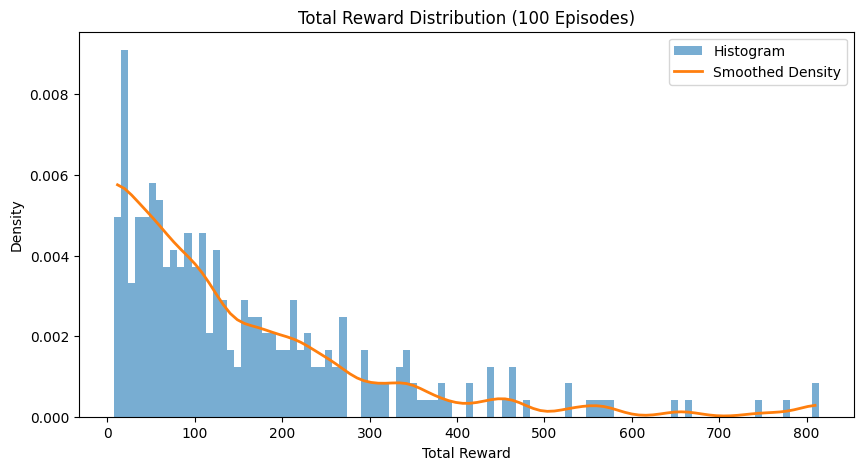

<Axes: title={'center': 'Total Reward Distribution (100 Episodes)'}, xlabel='Total Reward', ylabel='Density'>

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def plot_reward_distribution_with_density(
    metrics,
    bins=100,
    smoothing_sigma=2.0,
    title="Total Reward Distribution",
    xlabel="Total Reward",
    ylabel="Density",
    show=True,
    ax=None,
):
    """
    Plot a histogram of total rewards with a smooth density curve
    that follows the shape of the bins.

    Args:
        metrics (dict): Dictionary containing 'total_reward'.
        bins (int): Number of histogram bins.
        smoothing_sigma (float): Gaussian smoothing strength for the curve.
        title (str): Plot title.
        xlabel (str): X-axis label.
        ylabel (str): Y-axis label.
        show (bool): Whether to call plt.show().
        ax (matplotlib.axes.Axes, optional): Existing axes.

    Returns:
        matplotlib.axes.Axes
    """
    rewards = np.asarray(metrics["total_reward"])

    if ax is None:
        fig, ax = plt.subplots()

    # Histogram (normalized)
    counts, bin_edges, _ = ax.hist(
        rewards,
        bins=bins,
        density=True,
        alpha=0.6,
        label="Histogram"
    )

    # Bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Smooth the histogram counts
    smooth_counts = gaussian_filter1d(counts, sigma=smoothing_sigma)

    # Plot smooth curve
    ax.plot(
        bin_centers,
        smooth_counts,
        linewidth=2,
        label="Smoothed Density"
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

    if show:
        plt.show()

    return ax


plot_reward_distribution_with_density(
    metrics,
    bins=100,
    smoothing_sigma=2.5,
    title="Total Reward Distribution (100 Episodes)"
)



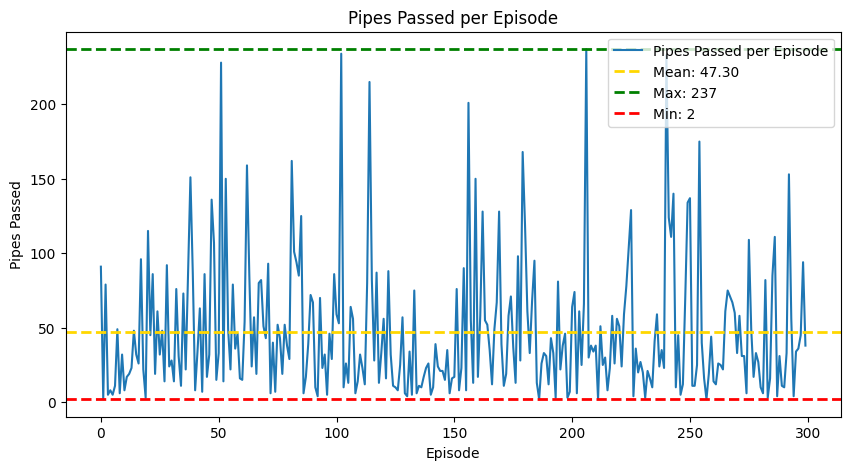

In [40]:
pipes = metrics["pipes_passed"]
mean_pipes = np.mean(pipes)
max_pipes = np.max(pipes)
min_pipes = np.min(pipes)

plt.plot(pipes, label="Pipes Passed per Episode")
plt.axhline(
    y=mean_pipes,
    linestyle="--",
    linewidth=2,
    color = "gold",
    label=f"Mean: {mean_pipes:.2f}"
)
plt.axhline(
    y=max_pipes,
    linestyle="--",
    linewidth=2,
    color = "green",
    label=f"Max: {max_pipes}",
)

plt.axhline(
    y=min_pipes,
    linestyle="--",
    linewidth=2,
    color = "red",
    label=f"Min: {min_pipes}",
)

plt.title("Pipes Passed per Episode")
plt.xlabel("Episode")
plt.ylabel("Pipes Passed")
plt.legend()
plt.show()


In [41]:
import json
import pandas as pd
from pathlib import Path

OUTPUT_DIR = Path("metrics")
OUTPUT_DIR.mkdir(exist_ok=True)


In [42]:
df = pd.DataFrame(metrics)
df.index.name = "episode"

csv_path = OUTPUT_DIR / "episodes.csv"
df.to_csv(csv_path)

print(f"✅ Episode metrics saved to {csv_path}")


✅ Episode metrics saved to metrics/episodes.csv
